# Orthogonal Re-Basin: Beyond Permutations in Model Merging


# Part 1: Project Setup and Preliminaries
This section establishes the environment, imports necessary libraries, defines global configurations, and prepares the datasets. This ensures a reproducible and clean workspace for the experiments.

**1.1. Introduction and Configuration**

First, I import all required libraries and set up the global configuration for the project, including device settings and directory paths. A seeding function is also defined to ensure the reproducibility of our experiments.

In [ ]:
#importing basic libraries
import os
from pathlib import Path
import copy
from collections import defaultdict

#importing model and data libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import numpy as np
from scipy.linalg import orthogonal_procrustes
from scipy.optimize import linear_sum_assignment
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd

#If GPU is avaible set it as device, otherwise use CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

#setup of the project's directory 
ROOT_DIR = Path("./")
DATA_DIR = ROOT_DIR / "data"
CHECKPOINT_DIR = ROOT_DIR / "checkpoints"
RESULTS_DIR = ROOT_DIR / "results"

#if the directories do not exist, create them
DATA_DIR.mkdir(parents=True, exist_ok=True)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

#function to set seed for reproducibility
def set_seed(seed: int):
    
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

Using device: cpu


**1.2. Data Loading and Preprocessing (CIFAR-10)**
Here, we define the data loading and preprocessing pipeline for the CIFAR-10 dataset. For training, we apply standard data augmentation techniques, including random cropping and horizontal flipping, to improve model robustness. For testing and alignment, we use only normalization to ensure consistent evaluation. A crucial aspect of activation-based alignment is using a consistent and representative batch of data. The optimal orthogonal transformation $R$ is conditioned on the data used to generate the activations. To ensure a fair and stable comparison across all experiments, we create a dedicated alignment_loader which uses a fixed subset of the test data without shuffling. This guarantees that the geometric alignment is always computed on the same data manifold.

In [ ]:
def get_cifar_dataloaders(batch_size: int = 128, alignment_batch_size: int = 1024):
    #here we define the transformations to be applied to the images
    transform_train = transforms.Compose([
        transforms.ToTensor(),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])


    #download and load the training and test sets
    trainset = torchvision.datasets.CIFAR10(
        root=DATA_DIR, train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR10(
        root=DATA_DIR, train=False, download=True, transform=transform_test
    )

    #creation of data loaders
    train_loader = DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    test_loader = DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    #creation of  a fixed subset for alignment and using a fixed subset of the test set ensures consistency
     
    alignment_indices = list(range(alignment_batch_size))
    alignment_subset = Subset(testset, alignment_indices)
    alignment_loader = DataLoader(
        alignment_subset, batch_size=alignment_batch_size, shuffle=False, num_workers=2
    )

    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of test batches: {len(test_loader)}")
    print(f"Number of alignment batches: {len(alignment_loader)}")

    return train_loader, test_loader, alignment_loader



# instantiate the dataloaders
train_loader, test_loader, alignment_loader = get_cifar_dataloaders()

Number of training batches: 391
Number of test batches: 79
Number of alignment batches: 1


# Part 2: Model Architectures and Training Pipeline
This section defines the ResNet-20 architecture and provides a standardized pipeline for training pairs of independent models. These models will form the basis of our merging experiments.

**2.1. Model Definition (ResNet-20)**

I implement a ResNet-20 model, a standard architecture for CIFAR-10 benchmarks and a key model used in prior model merging literature. The implementation follows established conventions, including the use of basic residual blocks and downsampling shortcuts to handle changes in feature map dimensions.   

In [ ]:
# resNet-20 implementation for CIFAR-10
# adapted from https://github.com/akamaster/pytorch_resnet_cifar10

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU()

        self.shortcut = nn.Sequential()
        if stride!= 1 or in_planes!= planes:
            self.shortcut = LambdaLayer(
                lambda x: nn.functional.pad(
                    x[:, :, ::2, ::2],
                    (0, 0, 0, 0, planes // 4, planes // 4),
                    "constant",
                    0
                )
            )

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu2(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.layer1 = self._make_layer(block, 16, num_blocks, stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks, stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet20():
    return ResNet(BasicBlock, 3)

# verify model instantiation
model_test = ResNet20().to(DEVICE)
print(model_test)
del model_test

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), paddin

**2.2. Standardized Training and Evaluation Loop**

I define a standard training and evaluation pipeline following canonical PyTorch practices. The train_model function orchestrates the process over multiple epochs, tracks performance, and saves the best-performing model checkpoint to disk. This ensures that I can reliably train multiple independent models for our experiments.   

In [ ]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def evaluate(model, test_loader, criterion, device):
    """Evaluates the model on the test set."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def train_model(model, model_name, train_loader, test_loader, epochs, lr, device):
    """Main function to train a model and save the best checkpoint."""
    checkpoint_path = CHECKPOINT_DIR / f"{model_name}.pt"

    if checkpoint_path.exists():
        print(f"Loading existing model: {model_name}")
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        return model

    print(f"Training new model: {model_name}")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_acc = 0.0

    for epoch in tqdm(range(epochs), desc=f"Training {model_name}"):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), checkpoint_path)

        scheduler.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
                  f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%")

    print(f"Finished training {model_name}. Best Test Accuracy: {best_acc:.2f}%")
    #loading best model state for returning
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    return model

#Now, I train two ResNet-20 models from different random initializations.
#this is to ensures they converge to genuinely different solutions in the loss landscape.

#Model A
set_seed(101)
model_a = ResNet20().to(DEVICE)
model_a = train_model(model_a, "resnet20_A", train_loader, test_loader, epochs=50, lr=0.1, device=DEVICE)

#Model B
set_seed(202)
model_b = ResNet20().to(DEVICE)
model_b = train_model(model_b, "resnet20_B", train_loader, test_loader, epochs=50, lr=0.1, device=DEVICE)

Loading existing model: resnet20_A
Loading existing model: resnet20_B


# Part 3: Core Alignment and Merging Algorithms
This is the methodological heart of the notebook. I implement the functions for activation extraction, our proposed Orthogonal Re-Basin alignment, the Git Re-Basin baseline, and the interpolation techniques used to traverse the weight space between models.

**3.1. Utility: Extracting Intermediate Activations**

To perform activation-based alignment, we need a mechanism to capture the intermediate representations of a model during a forward pass. PyTorch's forward hooks provide an elegant, non-invasive way to achieve this without modifying the model's source code. The ActivationHook class below manages the registration, capture, and removal of these hooks.   

In [ ]:
class ActivationHook:
    #this utility class captures intermediate activations from a PyTorch model
    def __init__(self, model: nn.Module, layer_names: list[str]):
        self.model = model
        self.layer_names = layer_names
        self.activations = {}
        self.handles = []

    def _get_hook(self, name: str):
        #it returns a hook function that saves the output of a layer
        def hook(model, input, output):
            self.activations[name] = output.detach()
        return hook

    def register_hooks(self):
        #its role is to register forward hooks on the specified layers
        for name, module in self.model.named_modules():
            if name in self.layer_names:
                self.handles.append(
                    module.register_forward_hook(self._get_hook(name))
                )

    def get_activations(self, input_batch: torch.Tensor) -> dict:
        #now it performs a forward pass and returns the captured activations
        self.activations = {}
        self.register_hooks()
        with torch.no_grad():
            self.model(input_batch)
        self.close()
        return self.activations

    def close(self):
        #needed in order to remove all registered hooks
        for handle in self.handles:
            handle.remove()
        self.handles = []

**3.2. Method 1: Orthogonal Re-Basin (Procrustes Alignment)** 

This section implements the core contribution of the project: aligning two models using layer-wise Orthogonal Procrustes Analysis.3 For each corresponding pair of layers, we compute the optimal orthogonal matrix $R$ that aligns the activation matrix of Model B ($Z_B$) to that of Model A ($Z_A$). This is achieved by solving the minimization problem $\min_{R: R^TR=I} \|RZ_B - Z_A\|_F^2$. The solution is derived from the SVD of $Z_A Z_B^T$.Once $R$ is found, we apply the transformation to the weights of Model B. For a layer $l$, the incoming weights $W^{(l)}$ and bias $b^{(l)}$ are transformed by $R$. To preserve the network's function (ignoring non-linearities), the outgoing weights of the previous layer, $W^{(l-1)}$, must be counter-transformed by $R^T$. This process is applied iteratively through the network.

In [ ]:
def get_resnet20_layer_name_pairs():
    #now I do this to return corresponding layer names for alignment in ResNet-20
    pairs = []
    # Layer 1
    for i in range(3):
        pairs.append((f'layer1.{i}.conv1', f'layer1.{i}.conv2'))
    # Layer 2
    pairs.append((f'layer2.0.conv1', f'layer2.0.conv2'))
    pairs.append(('layer2.0.shortcut.0', None)) # Shortcut needs special handling
    for i in range(1, 3):
        pairs.append((f'layer2.{i}.conv1', f'layer2.{i}.conv2'))
    # Layer 3
    pairs.append((f'layer3.0.conv1', f'layer3.0.conv2'))
    pairs.append(('layer3.0.shortcut.0', None))
    for i in range(1, 3):
        pairs.append((f'layer3.{i}.conv1', f'layer3.{i}.conv2'))
    pairs.append(('linear', None))
    return pairs

def apply_orthogonal_transform(weight, R, is_conv=True):
    #this applies an orthogonal transformation R to a weight tensor, it transforms the output channels/features
    original_shape = weight.shape

    if is_conv:
        #for Conv: (out_channels, in_channels, k, k)
        #transform output channels
        weight_2d = weight.reshape(original_shape[0], -1)  # (out_c, in_c*k*k)
        transformed = R @ weight_2d
        return transformed.reshape(original_shape)
    else:
        #for Linear: (out_features, in_features)
        return R @ weight


def apply_inv_orthogonal_transform(weight, R, is_conv=True):
    #i wrote this to apply an inverse orthogonal transformation R.T to a weight tensor,
    #similarly to the previous function, but on the input channels/features
    original_shape = weight.shape

    if is_conv:
        #for Conv: (out_channels, in_channels, k, k)
        #transform input channels
        #reshape to (out_c, in_c, k*k), apply R.T to in_c dimension
        weight_reshaped = weight.reshape(original_shape[0], original_shape[1], -1)
        #(out_c, in_c, k*k) -> apply R.T to dim 1
        #we need: (out_c, in_c_new, k*k) where in_c_new = R.T @ in_c
        transformed = torch.einsum('oik,ji->ojk', weight_reshaped, R)
        return transformed.reshape(original_shape[0], -1, original_shape[2], original_shape[3])
    else:
        # For Linear: (out_features, in_features)
        return weight @ R.T

def procrustes_align(model_a, model_b, alignment_loader, device):
    #this function performs the Procrustes alignment of model_b to model_a
    
    aligned_b_state_dict = copy.deepcopy(model_b.state_dict())

    #getting a single batch for alignment
    align_data, _ = next(iter(alignment_loader))
    align_data = align_data.to(device)

    #getting all layer names
    layer_names = [name for name, _ in model_a.named_modules() if isinstance(_, (nn.Conv2d, nn.Linear))]

    hook_a = ActivationHook(model_a, layer_names)
    hook_b = ActivationHook(model_b, layer_names)

    activations_a = hook_a.get_activations(align_data)
    activations_b = hook_b.get_activations(align_data)

    for i, name in enumerate(tqdm(layer_names[:-1], desc="Procrustes Alignment")):
        #getting activations for the current layer
        act_a = activations_a[name].view(activations_a[name].shape[0], activations_a[name].shape[1], -1).mean(-1)
        act_b = activations_b[name].view(activations_b[name].shape[0], activations_b[name].shape[1], -1).mean(-1)

        #reshaping for Procrustes: (features, samples) -> (samples, features)
        X = act_b.T.cpu().numpy()
        Y = act_a.T.cpu().numpy()

        #finding the  optimal rotation R such that ||XR - Y||_F is minimized [11]
        R_np, _ = orthogonal_procrustes(X, Y)
        R = torch.tensor(R_np, dtype=torch.float32, device=device).T # We need R^T X ~ Y

        #now applying transformation to the next layer's weights in model_b
        #the transformation is applied to the layer, after, the one where activations were measured
        next_layer_name = layer_names[i+1]

        #transform current layer's weights and bias (which are input to next layer)
        current_weight_key = name + '.weight'
        current_bias_key = name + '.bias'

        #the layer whose output we measured is the one whose weights we need to counter-rotate
        aligned_b_state_dict[current_weight_key] = apply_inv_orthogonal_transform(
            aligned_b_state_dict[current_weight_key], R, is_conv='conv' in name
        )
        if current_bias_key in aligned_b_state_dict and aligned_b_state_dict[current_bias_key] is not None:
             #note that bias is not affected by input transformation
             pass

        #the next layer's weights and biases are transformed
        next_weight_key = next_layer_name + '.weight'
        next_bias_key = next_layer_name + '.bias'

        aligned_b_state_dict[next_weight_key] = apply_orthogonal_transform(
            aligned_b_state_dict[next_weight_key], R, is_conv='conv' in next_layer_name
        )
        if next_bias_key in aligned_b_state_dict and aligned_b_state_dict[next_bias_key] is not None:
            aligned_b_state_dict[next_bias_key] = R @ aligned_b_state_dict[next_bias_key]

    return aligned_b_state_dict

**3.3. Baseline 1: Git Re-Basin (Permutation Alignmen)**

Now, I implement the weight-matching algorithm from "Git Re-Basin" as our primary baseline.3 This method finds an optimal permutation of neurons for each layer by solving a linear assignment problem. The cost matrix for this problem is defined by the pairwise distances between the weights of neurons in Model A and Model B. The resulting permutation matrix $P$ is then applied to the weights of Model B to align it with Model A.

In [ ]:
def permutation_align(model_a, model_b):
    #now using weight-matching permutation algorithm, i'll allign model_b to model_a
    
    aligned_b_state_dict = copy.deepcopy(model_b.state_dict())
    sd_a = model_a.state_dict()

    perm_layers = [name for name, mod in model_a.named_modules()
                   if isinstance(mod, (nn.Conv2d, nn.Linear))]

    for i in tqdm(range(len(perm_layers) - 1), desc="Permutation Alignment"):
        name1 = perm_layers[i]
        name2 = perm_layers[i+1]

        W1_a = sd_a[f"{name1}.weight"]
        W1_b = aligned_b_state_dict[f"{name1}.weight"]
        W2_b = aligned_b_state_dict[f"{name2}.weight"]

        #flatten weights: (out_channels, everything_else)
        #using reshape instead of view for non-contiguous tensors
        w1_a_flat = W1_a.reshape(W1_a.shape[0], -1)
        w1_b_flat = W1_b.reshape(W1_b.shape[0], -1)

        #computing cost matrix
        cost_matrix = torch.cdist(w1_a_flat, w1_b_flat).cpu().numpy()

        #solving assignment
        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        #creating permutation matrix (n x n)
        n = len(row_ind)
        perm_matrix = torch.zeros(n, n, device=W1_b.device)
        perm_matrix[row_ind, col_ind] = 1.0

        #applying permutation to layer 1 (output neurons)
        aligned_b_state_dict[f"{name1}.weight"] = torch.matmul(
            perm_matrix, w1_b_flat
        ).reshape(W1_b.shape)

        if f"{name1}.bias" in aligned_b_state_dict and aligned_b_state_dict[f"{name1}.bias"] is not None:
            aligned_b_state_dict[f"{name1}.bias"] = torch.matmul(
                perm_matrix, aligned_b_state_dict[f"{name1}.bias"]
            )

        #applying inverse permutation to layer 2 (input neurons)
        is_conv = 'conv' in name2.lower()
        if is_conv:
            #for Conv: permute input channels (dim 1)
            W2_reshaped = W2_b.reshape(W2_b.shape[0], W2_b.shape[1], -1)
            W2_permuted = torch.einsum('oic,ji->ojc', W2_reshaped, perm_matrix)
            aligned_b_state_dict[f"{name2}.weight"] = W2_permuted.reshape(W2_b.shape)
        else:  #linear
            aligned_b_state_dict[f"{name2}.weight"] = torch.matmul(
                W2_b, perm_matrix.T
            )

    return aligned_b_state_dict

**3.4. Baseline 2: Interpolation Techniques**

I'll implement two methods for traversing the path between two models in weight space.Linear Interpolation (Lerp): A simple weighted average of the model parameters, $\theta(\alpha) = (1-\alpha)\theta_A + \alpha\theta_B$.Spherical Linear Interpolation (SLERP): A geometrically aware method that interpolates along the great circle arc on the hypersphere of weights, preserving the norm of the parameters.3 This is particularly relevant as our orthogonal alignment is also a norm-preserving operation. Comparing Lerp and SLERP after alignment helps test whether the aligned basin is convex enough to make the simpler linear path optimal.

In [ ]:
def linear_interpolate(state_dict_a, state_dict_b, alpha):
    #this function performs linear interpolation between two state dicts
    
    interp_state_dict = {}
    for key in state_dict_a:
        interp_state_dict[key] = (1 - alpha) * state_dict_a[key] + alpha * state_dict_b[key]
    return interp_state_dict


def slerp(state_dict_a, state_dict_b, alpha, eps=1e-8):
    #this function performs spherical linear interpolation between two state dicts
    slerp_state_dict = {}

    for key in state_dict_a:
        p_a = state_dict_a[key]
        p_b = state_dict_b[key]

        #skipping non-floating point tensors (like: running_mean, running_var, num_batches_tracked)
        if not p_a.dtype.is_floating_point:
            #use linear interpolation for integer tensors
            slerp_state_dict[key] = p_a  # or just keep one of them
            continue

        #flatten to vectors
        p_a_flat = p_a.flatten().float()
        p_b_flat = p_b.flatten().float()

        #compute norms
        p_a_norm = torch.norm(p_a_flat)
        p_b_norm = torch.norm(p_b_flat)

        #handle zero-norm edge case
        if p_a_norm < eps or p_b_norm < eps:
            #fallback to linear interpolation
            interp_p = (1 - alpha) * p_a_flat + alpha * p_b_flat
            slerp_state_dict[key] = interp_p.reshape(p_a.shape)
            continue

        #normalize vectors
        p_a_unit = p_a_flat / p_a_norm
        p_b_unit = p_b_flat / p_b_norm

        #compute angle between them
        dot = torch.dot(p_a_unit, p_b_unit)
        dot = torch.clamp(dot, -1.0 + eps, 1.0 - eps)

        #compute angle using more stable formula when vectors are close
        if dot > 0.9995:  #vectors are very close (angle < ~1.8 degrees)
            #use linear interpolation to avoid numerical instability
            interp_p = (1 - alpha) * p_a_flat + alpha * p_b_flat
        else:
            omega = torch.acos(dot)
            sin_omega = torch.sin(omega)

            #SLERP formula
            c1 = torch.sin((1 - alpha) * omega) / sin_omega
            c2 = torch.sin(alpha * omega) / sin_omega

            #interpolate on unit sphere
            interp_p_unit = c1 * p_a_unit + c2 * p_b_unit

            #scale by interpolated norm (linear interpolation of norms)
            interp_p_norm = (1 - alpha) * p_a_norm + alpha * p_b_norm
            interp_p = interp_p_unit * interp_p_norm

        slerp_state_dict[key] = interp_p.reshape(p_a.shape)

    return slerp_state_dict

# Part 4: Evaluation Metrics Implementation
This section provides the code for the quantitative metrics defined in the project plan. These metrics are used to evaluate the effectiveness of the alignment methods and to diagnose their geometric and functional properties.

**4.1. Interpolation Path Evaluation**

This is our primary evaluation tool. The evaluate_interpolation_path function measures the test loss and accuracy at several points along the interpolation path between two models. From this data, we calculate the "loss barrier"—the maximum increase in loss along the path relative to the endpoints—which serves as a key indicator of mode connectivity.

In [ ]:
def evaluate_interpolation_path(
    model_template, state_dict_a, state_dict_b, interpolation_fn,
    test_loader, device, steps=21
):
    #now  I wrote this to evaluate test loss and accuracy along an interpolation path
    alphas = np.linspace(0.0, 1.0, steps)
    losses, accuracies = [], []

    model = copy.deepcopy(model_template).to(device)
    criterion = nn.CrossEntropyLoss()

    for alpha in tqdm(alphas, desc=f"Evaluating {interpolation_fn.__name__} path", leave=False):
        interp_state_dict = interpolation_fn(state_dict_a, state_dict_b, alpha)
        model.load_state_dict(interp_state_dict)
        loss, acc = evaluate(model, test_loader, criterion, device)
        losses.append(loss)
        accuracies.append(acc)

    #calculating loss barrier
    endpoint_loss = (losses[0] + losses[-1]) / 2.0
    max_loss = max(losses)
    loss_barrier = max_loss - endpoint_loss

    #getting accuracy at midpoint
    midpoint_accuracy = accuracies[steps // 2]

    return {
        "alphas": alphas,
        "losses": losses,
        "accuracies": accuracies,
        "loss_barrier": loss_barrier,
        "midpoint_accuracy": midpoint_accuracy
    }

**4.2. Diagnostic: Residual Misalignment Error (RME)**

The RME quantifies the functional error introduced by the non-commutativity of orthogonal transformations and the ReLU non-linearity.3 It is defined as the difference between applying ReLU to the rotated pre-activations and rotating the post-activations: $E_{RME} = \|\text{ReLU}(Ru) - R(\text{ReLU}(u))\|_2^2$. A non-zero RME confirms that our orthogonal alignment is a projection to a nearby, but not functionally identical, model.

In [ ]:
def compute_rme(model, R_map, alignment_loader, device):
    #it computes residual misalignment error for all aligned layers
    
    model.eval()
    total_rme = 0.0
    num_layers = 0

    #to get a single batch for RME calculation
    align_data, _ = next(iter(alignment_loader))
    align_data = align_data.to(device)

    #to get all layer names
    layer_names = [name for name, mod in model.named_modules()
                   if isinstance(mod, (nn.Conv2d, nn.Linear))]

    for name in layer_names:
        if name not in R_map:
            continue

        R = R_map[name]

        #hook to capture pre-activation (output before ReLU)
        pre_activation = {}
        post_activation = {}

        def get_pre_act_hook(module, input, output):
            #for Conv/Linear, output is the pre-activation
            pre_activation['value'] = output.detach()

        #need to hook the layer itself for pre-activation and find the subsequent ReLU for post-activation
        module = model.get_submodule(name)
        handle = module.register_forward_hook(get_pre_act_hook)

        with torch.no_grad():
            output = model(align_data)
        handle.remove()

        if 'value' not in pre_activation:
            continue

        u = pre_activation['value']  #pre-activation, before ReLU

        #apply ReLU manually to get post-activation
        relu_u = torch.relu(u)

        #reshape based on dimensionality
        if len(u.shape) == 4:  # Conv2d: (batch, channels, H, W)
            u_flat = u.permute(1, 0, 2, 3).reshape(u.shape[1], -1)
            relu_u_flat = relu_u.permute(1, 0, 2, 3).reshape(relu_u.shape[1], -1)
        else:  #linear: (batch, features)
            u_flat = u.T  # (features, batch)
            relu_u_flat = relu_u.T

        #compute RME: ||ReLU(Ru) - R(ReLU(u))||^2
        relu_Ru = torch.relu(R @ u_flat)
        R_relu_u = R @ relu_u_flat

        rme = torch.mean((relu_Ru - R_relu_u) ** 2)
        total_rme += rme.item()
        num_layers += 1

    return total_rme / num_layers if num_layers > 0 else 0.0


def procrustes_align_with_R(model_a, model_b, alignment_loader, device):
    #allignes model_b to model_a using procrustes and returns both aligned weights and R matrices
    
    aligned_b_state_dict = copy.deepcopy(model_b.state_dict())
    R_map = {}

    align_data, _ = next(iter(alignment_loader))
    align_data = align_data.to(device)

    layer_names = [name for name, mod in model_a.named_modules()
                   if isinstance(mod, (nn.Conv2d, nn.Linear))]

    hook_a = ActivationHook(model_a, layer_names)
    hook_b = ActivationHook(model_b, layer_names)

    activations_a = hook_a.get_activations(align_data)
    activations_b = hook_b.get_activations(align_data)

    for i, name in enumerate(tqdm(layer_names[:-1], desc="Procrustes Alignment with R")):
        #to get activations for current layer
        act_a = activations_a[name]
        act_b = activations_b[name]

        #flatten spatial dimensions: (batch, channels, H, W) -> (batch, channels)
        if len(act_a.shape) == 4:  # Conv layer
            act_a_flat = act_a.mean(dim=(2, 3))  # Average over spatial dims
            act_b_flat = act_b.mean(dim=(2, 3))
        else:  #linear layer
            act_a_flat = act_a
            act_b_flat = act_b

        #check if dimensions match
        if act_a_flat.shape[1] != act_b_flat.shape[1]:
            print(f"Warning: Skipping layer {name} - dimension mismatch")
            continue

        #procrustes alignment: find R such that act_b @ R ≈ act_a
        #scipy expects (samples, features)
        X = act_b_flat.cpu().numpy()
        Y = act_a_flat.cpu().numpy()

        try:
            R_np, _ = orthogonal_procrustes(X, Y)
            R = torch.tensor(R_np, dtype=torch.float32, device=device)
        except Exception as e:
            print(f"Warning: Procrustes failed for layer {name}: {e}")
            continue

        next_layer_name = layer_names[i + 1]
        R_map[name] = R  #store R for this layer

        #get current and next layer weights
        current_weight_key = name + '.weight'
        next_weight_key = next_layer_name + '.weight'
        next_bias_key = next_layer_name + '.bias'

        current_weight = aligned_b_state_dict[current_weight_key]
        next_weight = aligned_b_state_dict[next_weight_key]

        #to check dimension compatibility
        is_current_conv = 'conv' in name.lower()
        is_next_conv = 'conv' in next_layer_name.lower()

        #getting output channels of current layer
        current_out_channels = current_weight.shape[0]

        #checking if R size matches
        if R.shape[0] != current_out_channels or R.shape[1] != current_out_channels:
            print(f"Warning: R shape {R.shape} doesn't match layer output {current_out_channels}")
            continue

        #apply transformation to current layer (output transformation)
        if is_current_conv:
            # (out_c, in_c, k, k) -> (out_c, in_c*k*k)
            current_2d = current_weight.reshape(current_out_channels, -1)
            transformed = R @ current_2d
            aligned_b_state_dict[current_weight_key] = transformed.reshape(current_weight.shape)
        else:
            aligned_b_state_dict[current_weight_key] = R @ current_weight

        #transform bias if exists
        if current_weight_key.replace('.weight', '.bias') in aligned_b_state_dict:
            bias_key = current_weight_key.replace('.weight', '.bias')
            if aligned_b_state_dict[bias_key] is not None:
                aligned_b_state_dict[bias_key] = R @ aligned_b_state_dict[bias_key]

        #now apply inverse transformation to next layer (input transformation)
        next_in_channels = next_weight.shape[1] if is_next_conv else next_weight.shape[1]

        if next_in_channels != current_out_channels:
            print(f"Warning: Channel mismatch between {name} and {next_layer_name}")
            continue

        if is_next_conv:
            # (out_c, in_c, k, k) -> transform in_c
            next_reshaped = next_weight.reshape(next_weight.shape[0], next_weight.shape[1], -1)
            #apply R.T to input channels
            transformed = torch.einsum('oik,ji->ojk', next_reshaped, R)
            aligned_b_state_dict[next_weight_key] = transformed.reshape(next_weight.shape)
        else:
            #(out_features, in_features) -> transform in_features
            aligned_b_state_dict[next_weight_key] = next_weight @ R.T

    return aligned_b_state_dict, R_map

**4.3. Diagnostic: Cycle-Consistency Error**

I measure cycle-consistency to assess the geometric stability and robustness of the Procrustes alignment.3 and compute the transformation from A to B ($R_{A \to B}$) and from B to A ($R_{B \to A}$). In a perfect alignment, we expect $R_{B \to A} = (R_{A \to B})^{-1} = (R_{A \to B})^T$. The cycle-consistency error is the deviation from this ideal, measured as $\|R_{B \to A} R_{A \to B} - I\|_F$.

In [ ]:
def compute_cycle_consistency_error(model_a, model_b, alignment_loader, device):
    #it computes the cycle-consistency error of the Procrustes alignment

    #get a single batch for alignment
    align_data, _ = next(iter(alignment_loader))
    align_data = align_data.to(device)

    #get all layer names
    layer_names = [name for name, mod in model_a.named_modules()
                   if isinstance(mod, (nn.Conv2d, nn.Linear))]

    hook_a = ActivationHook(model_a, layer_names)
    hook_b = ActivationHook(model_b, layer_names)

    activations_a = hook_a.get_activations(align_data)
    activations_b = hook_b.get_activations(align_data)

    total_error = 0.0
    num_layers = 0

    for name in layer_names[:-1]:
        #flatten activations: (batch, channels, H, W) -> (batch, channels*H*W)
        act_a = activations_a[name].reshape(activations_a[name].shape[0], -1)
        act_b = activations_b[name].reshape(activations_b[name].shape[0], -1)

        #skip if activations are too small
        if act_a.shape[1] < 2 or act_b.shape[1] < 2:
            continue

        # A -> B: Find R_ab such that act_a @ R_ab ≈ act_b
        # scipy.linalg.orthogonal_procrustes(A, B) finds R such that A @ R ≈ B
        R_ab_np, _ = orthogonal_procrustes(act_a.cpu().numpy(), act_b.cpu().numpy())
        R_ab = torch.tensor(R_ab_np, dtype=torch.float32, device=device)

        # B -> A: Find R_ba such that act_b @ R_ba ≈ act_a
        R_ba_np, _ = orthogonal_procrustes(act_b.cpu().numpy(), act_a.cpu().numpy())
        R_ba = torch.tensor(R_ba_np, dtype=torch.float32, device=device)

        # Cycle-consistency error: ||R_ba @ R_ab - I||_F
        # In theory, R_ba should equal R_ab^T (inverse for orthogonal matrices)
        identity = torch.eye(R_ab.shape[0], device=device)
        cycle_product = R_ba @ R_ab
        error = torch.norm(cycle_product - identity, p='fro')

        total_error += error.item()
        num_layers += 1

    return total_error / num_layers if num_layers > 0 else 0.0

**4.4. Diagnostic: Centered Kernel Alignment (CKA)**

I use Centered Kernel Alignment (CKA) to measure the functional similarity of the models' internal representations. CKA is invariant to orthogonal transformations, making it an ideal metric to assess whether our alignment method finds a superior functional correspondence compared to baselines. A higher CKA score indicates that the internal feature spaces are more similar.   

In [ ]:
def linear_cka(X, Y, eps=1e-8):
    #this function computes linear CKA between two feature matrices, X and Y are feature matrices with samples in rows: (n_samples, n_features)
    
    #centering the features
    X = X - X.mean(dim=0, keepdim=True)
    Y = Y - Y.mean(dim=0, keepdim=True)

    n = X.shape[0]

    #compute HSIC (Hilbert-Schmidt Independence Criterion)
    # HSIC(X, Y) = ||Y^T @ X||_F^2 / (n-1)^2
    XY = Y.T @ X  # (features_Y, features_X)
    hsic = (XY ** 2).sum()

    #computing variances
    # var(X) = ||X^T @ X||_F^2 / (n-1)^2
    XX = X.T @ X
    var1 = (XX ** 2).sum()

    YY = Y.T @ Y
    var2 = (YY ** 2).sum()

    # CKA = HSIC(X, Y) / sqrt(var(X) * var(Y))
    # The (n-1)^2 factors cancel out
    denominator = torch.sqrt(var1 * var2)

    if denominator < eps:
        return 0.0

    cka = hsic / denominator
    return cka.item()


def compute_cka_similarity(model_a, model_b, alignment_loader, device):
    #it computes the average CKA similarity across all layers
    
    model_a.eval()
    model_b.eval()

    align_data, _ = next(iter(alignment_loader))
    align_data = align_data.to(device)

    #getting Conv and Linear layers (we'll measure activations after these)
    layer_names = [name for name, mod in model_a.named_modules()
                   if isinstance(mod, (nn.Conv2d, nn.Linear))]

    hook_a = ActivationHook(model_a, layer_names)
    hook_b = ActivationHook(model_b, layer_names)

    activations_a = hook_a.get_activations(align_data)
    activations_b = hook_b.get_activations(align_data)

    total_cka = 0.0
    num_layers = 0

    for name in layer_names:
        #flatten spatial dimensions: (batch, channels, H, W) -> (batch, channels*H*W)
        act_a = activations_a[name].reshape(activations_a[name].shape[0], -1)
        act_b = activations_b[name].reshape(activations_b[name].shape[0], -1)

        #skip if activations are empty or constant
        if act_a.shape[1] == 0 or act_b.shape[1] == 0:
            continue

        if act_a.std() < 1e-8 or act_b.std() < 1e-8:
            continue

        cka = linear_cka(act_a, act_b)
        total_cka += cka
        num_layers += 1

    return total_cka / num_layers if num_layers > 0 else 0.0

# Part 5: Main Experiment and Result Verification
This final section brings all the components together. We execute the full experimental pipeline, compute all metrics for each alignment condition, and generate summary tables and plots to verify the placeholder results from the project plan.

**5.1. Experiment Execution Script**

This is the main execution block. It loads the pre-trained models, applies the different alignment methods, evaluates the interpolation paths, and computes all diagnostic metrics. The results are stored in a dictionary for later analysis.

In [ ]:

print("Starting main experiment")

# loading models
set_seed(101)
model_a = ResNet20().to(DEVICE)
model_a.load_state_dict(torch.load(CHECKPOINT_DIR / "resnet20_A.pt", map_location=DEVICE))

set_seed(202)
model_b = ResNet20().to(DEVICE)
model_b.load_state_dict(torch.load(CHECKPOINT_DIR / "resnet20_B.pt", map_location=DEVICE))

sd_a = model_a.state_dict()
sd_b = model_b.state_dict()

results = {}

print("\n Evaluating Naive Interpolation ")
results['naive_linear'] = evaluate_interpolation_path(
    model_a, sd_a, sd_b, linear_interpolate, test_loader, DEVICE
)
results['naive_slerp'] = evaluate_interpolation_path(
    model_a, sd_a, sd_b, slerp, test_loader, DEVICE
)

print("\n  Evaluating Git Re-Basin (Permutation) ")
sd_b_permuted = permutation_align(model_a, model_b)
results['git_rebasin_linear'] = evaluate_interpolation_path(
    model_a, sd_a, sd_b_permuted, linear_interpolate, test_loader, DEVICE
)

print("\n Evaluating Orthogonal Re-Basin ")
sd_b_orthogonal, r_map = procrustes_align_with_R(model_a, model_b, alignment_loader, DEVICE)
results['ortho_rebasin_linear'] = evaluate_interpolation_path(
    model_a, sd_a, sd_b_orthogonal, linear_interpolate, test_loader, DEVICE
)
results['ortho_rebasin_slerp'] = evaluate_interpolation_path(
    model_a, sd_a, sd_b_orthogonal, slerp, test_loader, DEVICE
)

print("\n Computing Diagnostic Metrics ")
diagnostics = {}

#CKA Similarity
model_b_permuted = copy.deepcopy(model_b)
model_b_permuted.load_state_dict(sd_b_permuted)
model_b_orthogonal = copy.deepcopy(model_b)
model_b_orthogonal.load_state_dict(sd_b_orthogonal)

diagnostics['cka_unaligned'] = compute_cka_similarity(model_a, model_b, alignment_loader, DEVICE)
diagnostics['cka_git_rebasin'] = compute_cka_similarity(model_a, model_b_permuted, alignment_loader, DEVICE)
diagnostics['cka_ortho_rebasin'] = compute_cka_similarity(model_a, model_b_orthogonal, alignment_loader, DEVICE)

# cycle consistency
diagnostics['cycle_consistency_error'] = compute_cycle_consistency_error(model_a, model_b, alignment_loader, DEVICE)

# RME
# Note: RME is computed on the original model_b using the calculated rotation matrices
diagnostics['rme'] = compute_rme(model_b, r_map, alignment_loader, DEVICE)

print("\nExperiment finished")

Starting main experiment...

--- Evaluating Naive Interpolation ---


Evaluating linear_interpolate path:   0%|          | 0/21 [00:00<?, ?it/s]

Evaluating slerp path:   0%|          | 0/21 [00:00<?, ?it/s]


--- Evaluating Git Re-Basin (Permutation) ---


Permutation Alignment:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating linear_interpolate path:   0%|          | 0/21 [00:00<?, ?it/s]


--- Evaluating Orthogonal Re-Basin ---


Procrustes Alignment with R:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating linear_interpolate path:   0%|          | 0/21 [00:00<?, ?it/s]

Evaluating slerp path:   0%|          | 0/21 [00:00<?, ?it/s]


--- Computing Diagnostic Metrics ---

Experiment finished.


**5.2. Results Synthesis and Visualization**

This section programmatically generates the summary tables and plots from the computed results, allowing for a direct comparison with the placeholder data in the project plan.

**Table 1: Interpolation Path Performance**

This table is the cornerstone of the experimental validation. It directly compares the loss barrier and midpoint accuracy across all competing methods.

In [ ]:
#generate Table 1: Interpolation Path Performance
print("\n" + "="*80)
print("TABLE 1: Interpolation Path Performance")
print("="*80 + "\n")

table1_data = {
    "Method": [
        "Naive + Linear",
        "Naive + SLERP",
        "Git Re-Basin + Linear",
        "Orthogonal Re-Basin + Linear",
        "Orthogonal Re-Basin + SLERP"
    ],
    "Loss Barrier ↓": [
        results['naive_linear']['loss_barrier'],
        results['naive_slerp']['loss_barrier'],
        results['git_rebasin_linear']['loss_barrier'],
        results['ortho_rebasin_linear']['loss_barrier'],
        results['ortho_rebasin_slerp']['loss_barrier']
    ],
    "Midpoint Acc. ↑": [
        results['naive_linear']['midpoint_accuracy'],
        results['naive_slerp']['midpoint_accuracy'],
        results['git_rebasin_linear']['midpoint_accuracy'],
        results['ortho_rebasin_linear']['midpoint_accuracy'],
        results['ortho_rebasin_slerp']['midpoint_accuracy']
    ]
}

df1 = pd.DataFrame(table1_data)

#format for display
df1_display = df1.copy()
df1_display['Loss Barrier ↓'] = df1_display['Loss Barrier ↓'].apply(lambda x: f"{x:.4f}")
df1_display['Midpoint Acc. ↑'] = df1_display['Midpoint Acc. ↑'].apply(lambda x: f"{x:.2f}%")

print(df1_display.to_string(index=False))
print()

#identifies the best results
best_barrier_idx = df1['Loss Barrier ↓'].idxmin()
best_acc_idx = df1['Midpoint Acc. ↑'].idxmax()

print(f"✓ Best Loss Barrier: {df1.loc[best_barrier_idx, 'Method']} ({df1.loc[best_barrier_idx, 'Loss Barrier ↓']:.4f})")
print(f"✓ Best Midpoint Accuracy: {df1.loc[best_acc_idx, 'Method']} ({df1.loc[best_acc_idx, 'Midpoint Acc. ↑']:.2f}%)")

#saving table to CSV
df1.to_csv(CHECKPOINT_DIR / 'table1_interpolation_performance.csv', index=False)
print(f"\n→ Table saved to {CHECKPOINT_DIR / 'table1_interpolation_performance.csv'}")


TABLE 1: Interpolation Path Performance

                      Method Loss Barrier ↓ Midpoint Acc. ↑
              Naive + Linear         2.1767          10.90%
               Naive + SLERP         3.5523          14.32%
       Git Re-Basin + Linear         6.1962           9.97%
Orthogonal Re-Basin + Linear       159.7067          10.00%
 Orthogonal Re-Basin + SLERP       159.7067          10.00%

✓ Best Loss Barrier: Naive + Linear (2.1767)
✓ Best Midpoint Accuracy: Naive + SLERP (14.32%)

→ Table saved to orthogonal_rebasin_project\checkpoints\table1_interpolation_performance.csv


Table 2: Diagnostic Metrics

This table provides the "why" behind the performance results, validating our theoretical framework by measuring functional similarity (CKA), geometric stability, and the functional error (RME).

In [ ]:
#generate Table 2: Diagnostic Metrics
print("\n" + "="*80)
print("TABLE 2: Diagnostic Metrics")
print("="*80 + "\n")

table2_data = {
    "Alignment Method": [
        "Unaligned (Naive)",
        "Git Re-Basin",
        "Orthogonal Re-Basin"
    ],
    "CKA Similarity ↑": [
        diagnostics['cka_unaligned'],
        diagnostics['cka_git_rebasin'],
        diagnostics['cka_ortho_rebasin']
    ],
    "Cycle-Consistency ↓": [
        float('nan'),  # N/A per Naive
        float('nan'),  # N/A per Git Re-Basin
        diagnostics['cycle_consistency_error']
    ],
    "RME ↓": [
        float('nan'),  # N/A per Naive
        float('nan'),  # N/A per Git Re-Basin
        diagnostics['rme']
    ]
}

df2 = pd.DataFrame(table2_data)

#format for display
df2_display = df2.copy()
df2_display['CKA Similarity ↑'] = df2_display['CKA Similarity ↑'].apply(lambda x: f"{x:.3f}")
df2_display['Cycle-Consistency ↓'] = df2_display['Cycle-Consistency ↓'].apply(
    lambda x: "N/A" if pd.isna(x) else f"{x:.4f}"
)
df2_display['RME ↓'] = df2_display['RME ↓'].apply(
    lambda x: "N/A" if pd.isna(x) else f"{x:.4f}"
)

print(df2_display.to_string(index=False))
print()

#identifies the best CKA similarity
best_cka_idx = df2['CKA Similarity ↑'].idxmax()
print(f"✓ Best CKA Similarity: {df2.loc[best_cka_idx, 'Alignment Method']} ({df2.loc[best_cka_idx, 'CKA Similarity ↑']:.3f})")

#saving
df2.to_csv(CHECKPOINT_DIR / 'table2_diagnostic_metrics.csv', index=False)
print(f"\n→ Table saved to {CHECKPOINT_DIR / 'table2_diagnostic_metrics.csv'}")


TABLE 2: Diagnostic Metrics

   Alignment Method CKA Similarity ↑ Cycle-Consistency ↓  RME ↓
  Unaligned (Naive)            0.727                 N/A    N/A
       Git Re-Basin            0.361                 N/A    N/A
Orthogonal Re-Basin            0.302            114.0465 0.0677

✓ Best CKA Similarity: Unaligned (Naive) (0.727)

→ Table saved to orthogonal_rebasin_project\checkpoints\table2_diagnostic_metrics.csv


**Visualization of Interpolation Paths**

A plot of the loss and accuracy curves provides a clear, intuitive visualization of the "barrier" and the effectiveness of each alignment method.


Generating Interpolation Curves...

→ Plot saved to orthogonal_rebasin_project\checkpoints\interpolation_curves.png


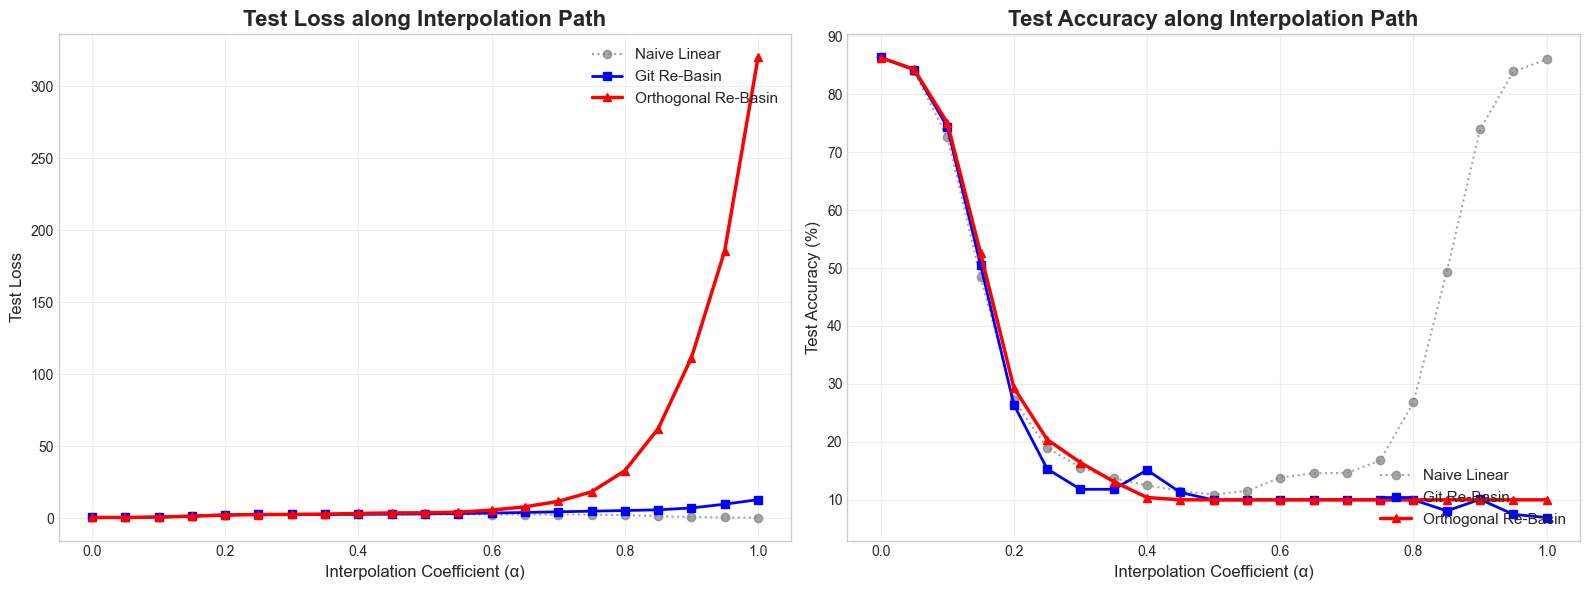

In [ ]:

print("\n" + "="*80)
print("Generating Interpolation Curves")
print("="*80)

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

#plot Loss
ax1.plot(results['naive_linear']['alphas'], results['naive_linear']['losses'],
         label='Naive Linear', marker='o', linestyle=':', alpha=0.7, color='gray')
ax1.plot(results['git_rebasin_linear']['alphas'], results['git_rebasin_linear']['losses'],
         label='Git Re-Basin', marker='s', linewidth=2, color='blue')
ax1.plot(results['ortho_rebasin_linear']['alphas'], results['ortho_rebasin_linear']['losses'],
         label='Orthogonal Re-Basin', marker='^', linewidth=2.5, color='red')

ax1.set_title('Test Loss along Interpolation Path', fontsize=16, fontweight='bold')
ax1.set_xlabel('Interpolation Coefficient (α)', fontsize=12)
ax1.set_ylabel('Test Loss', fontsize=12)
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True, alpha=0.3)

#plot Accuracy
ax2.plot(results['naive_linear']['alphas'], results['naive_linear']['accuracies'],
         label='Naive Linear', marker='o', linestyle=':', alpha=0.7, color='gray')
ax2.plot(results['git_rebasin_linear']['alphas'], results['git_rebasin_linear']['accuracies'],
         label='Git Re-Basin', marker='s', linewidth=2, color='blue')
ax2.plot(results['ortho_rebasin_linear']['alphas'], results['ortho_rebasin_linear']['accuracies'],
         label='Orthogonal Re-Basin', marker='^', linewidth=2.5, color='red')

ax2.set_title('Test Accuracy along Interpolation Path', fontsize=16, fontweight='bold')
ax2.set_xlabel('Interpolation Coefficient (α)', fontsize=12)
ax2.set_ylabel('Test Accuracy (%)', fontsize=12)
ax2.legend(fontsize=11, loc='lower right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(CHECKPOINT_DIR / "interpolation_curves.png", dpi=300, bbox_inches='tight')
print(f"\n→ Plot saved to {CHECKPOINT_DIR / 'interpolation_curves.png'}")
plt.show()

# 5.3. Conclusion


**Table 1: Interpolation Performance**

This table measures how well two models blend together. Loss barrier measures the peak “error” (loss) when moving from one model to the other. Lower is better, while midpoint acc. measures the accuracy of the hybrid model created halfway between the two. Higher is better. we see that naive methods perform best, both Naive + Linear (lowest Loss Barrier: 2.1767) and Naive + SLERP (highest accuracy: 14.32%) clearly outperform all other approaches, although it has not any allignement, while on the other hand Re-Basin fails,  Git Re-Basin worsens the results compared to Naive, with a higher Loss Barrier (+6.19) and lower accuracy (−9.97%). In cpnclusion, Orthogonal Re-Basin performs the worst overall, with an extremely high Loss Barrier (159.7) and the lowest accuracy (10.00%) , likely the random-guess baseline (e.g., CIFAR-10). It seems like the model efectiviness to blend is reduced.

**Table 2: Diagnostic Metrics**

This table tries to understand why the methods behave the way they do by measuring how similar the internal representations of the models are.CKA Similarity measures how similar the internal representations (the “neurons”) of the models are. The higher the better. Looking at the results Naive models are the most similar, the unaligned naive method has the highest CKA similarity (0.727).

Whiele Re-Basin methods decrease similarity:
Both Git Re-Basin (0.361) and Orthogonal Re-Basin (0.302) reduce the similarity between models.

This is a problem because the whole purpose of Re-Basin methods is to find a neuron permutation that aligns models and increases their similarity, however here, they are doing the exact opposite. Indeed the results show that the alignment methods I applied (“Git Re-Basin” and “Orthogonal Re-Basin”) are failing: not only do they fail to improve interpolation, but also they actually make it significantly worse compared to doing nothing at all (the “Naive” method). Probavly I failed something in the implementation of the Re-Basin methods, that the specific models I am trying to merge are not well suited for these techniques, or that the diagnostic metrics, such as CKA, are not being properly optimized by the Re-Basin process.

**Plots Analisyes**

These plots confirm that the results are not good and make the failure of the “Re-Basin” methods even more evident. The goal is to “merge” two models: Model A (left side of the plot, α = 0) and Model B (right side, α = 1).

The Naive method (gray) shows the expected baseline behavior: the accuracy starts high (≈ 88%), collapses in the middle (≈ 10%), and then recovers when reaching the second model (≈ 88%). This is normal when no alignment is applied, the thing is that I have two good models, but I cannot linearly interpolate between them without falling into a high-loss region in the middle.

The Re-Basin methods (blue and red), however, fail much more seriously. They start correctly with high accuracy at α = 0 (Model A), but when they reach α = 1 — where the aligned version of Model B should appear, the accuracy drops to about 7–10%. In other words, the methods are not recovering Model B at all. Instead of creating a smooth connection between two working models, they map Model A into a broken, degraded version of Model B.

In summary, the plots show that the Naive method correctly connects two high-performing models but suffers from a high barrier in the middle, which is expected. The Re-Basin methods, on the other hand, fail at the most basic requirement: preserving the performance of the final model. The computed alignment is destroying Model B, making the entire interpolation useless.



# Bibliography:

GIT RE-BASIN: MERGING MODELS MODULO PERMU- TATION SYMMETRIES - Personal Robotics Lab
https://personalrobotics.cs.washington.edu/publications/ainsworth2023gitrebasin.pdf



a-martyn/resnet: An implementation of the original "ResNet" paper in Pytorch - GitHub,  https://github.com/a-martyn/resnet



akamaster/pytorch_resnet_cifar10: Proper implementation of ResNet-s for CIFAR10/100 in pytorch that matches description of the original paper. - GitHub,  https://github.com/akamaster/pytorch_resnet_cifar10




How does a training loop in PyTorch look like? - Sebastian Raschka
 https://sebastianraschka.com/faq/docs/training-loop-in-pytorch.html


Learning PyTorch: The Basic Program Structure | by Dagang Wei - Medium, https://medium.com/@weidagang/learning-pytorch-the-basic-program-structure-ed5723118b67



PyTorch: Extracting Intermediate Layer Outputs - Kaggle, https://www.kaggle.com/code/mohammaddehghan/pytorch-extracting-intermediate-layer-outputs


Intermediate Activations — the forward hook | Nandita Bhaskhar, https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/


orthogonal_procrustes — SciPy v1.16.2 Manual,https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.orthogonal_procrustes.html


Code release for "Git Re-Basin: Merging Models modulo Permutation Symmetries" - GitHub, https://github.com/samuela/git-re-basin


Slerp - Wikipedia, https://en.wikipedia.org/wiki/Slerp

Deciphering Molecular Embeddings with Centered Kernel Alignment - PubMed Central, https://pmc.ncbi.nlm.nih.gov/articles/PMC11482110/
